In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)
from statannotations.Annotator import Annotator

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Data and functions

In [2]:
#load joint-rpca results
nPCs = 4
ord_18S = OrdinationResults.read('../results/joint-rpca/Ordinations/18S_ord_{}PCs.txt'.format(nPCs))
ord_mag = OrdinationResults.read('../results/joint-rpca/Ordinations/mag_ord_{}PCs.txt'.format(nPCs))
ord_gene = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_ord_{}PCs.txt'.format(nPCs))
ord_gene_module = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_module_ord_{}PCs.txt'.format(nPCs))
ord_metabolite = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(nPCs))
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [11]:
def rf_regression(ord_tables, ord_ids, shared_mt, cat_of_interest,
                  ordination=True, n_folds=10, n_estimators=100, 
                  random_state=42, optimize=False, param_grid=None, 
                  criterion="squared_error", bootstrap=True, 
                  cv_scoring='explained_variance', **kwargs):

    criterion_ord = {}
    
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        
        if ordination:
            X = ord.samples.copy()
        else: 
            X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        criterion_fold = {}

        for fold in ['traintest_{}'.format(i) for i in range(n_folds)]:
            
            #split data into pre-defined train and test sets
            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if optimize:
                print(f'Optimizing hyperparameters for {omic}, {fold}...')
                #initialize random forest
                rf = RandomForestRegressor(random_state=random_state,
                                           criterion=criterion, **kwargs)
                #hyperparameter optimization
                grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                           cv=5, n_jobs=-1, verbose=0, 
                                           scoring=cv_scoring)
                grid_search.fit(X_train.values, y_train)
                
                print('Best parameters found: {}'.format(grid_search.best_params_))
                print('Best CV {}: {}'.format(cv_scoring, grid_search.best_score_))

                #save best parameters
                best_params = grid_search.best_params_.copy()
                best_params['best_score'] = grid_search.best_score_
                #get best model
                best_rf = grid_search.best_estimator_
            
            else:
                #initialize random forest with user-defined parameters
                rf = RandomForestRegressor(n_estimators=n_estimators, 
                                           bootstrap=bootstrap,
                                           random_state=random_state, 
                                           criterion=criterion, **kwargs)
                rf.fit(X_train.values, y_train)
                best_params = 'None'
                best_rf = rf
            
            #predict on test set
            y_pred = best_rf.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            #save results for each fold
            criterion_fold[fold] = (mse, mae, best_params)
        
        #save results for each omic
        criterion_ord[omic] = criterion_fold

    #initialize dataframes to store results
    criterion_metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'MSE', 
                                                 'MAE', 'Optimization'])
    
    #create df with metrics
    for omic, criterion_fold in criterion_ord.items():
        for fold, metrics in criterion_fold.items():
            criterion_metrics_df = criterion_metrics_df._append(
                {'Omic': omic, 'Fold': fold, 
                 'MSE': metrics[0], 'MAE': metrics[1],
                 'Optimization': metrics[2]}, ignore_index=True)
    
    return criterion_metrics_df

## Ordination-based regression

### RF with default parameters

In [12]:
#add 0c with criterion = squared_error (MSE)
rf_reg_add = rf_regression(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                       ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],  
                           shared_mt=metadata, cat_of_interest='add_0c', 
                           criterion="squared_error", ordination=True, 
                           random_state=42, bootstrap=True)

display(rf_reg_add.head())

,Omic,Fold,MSE,MAE,Optimization
0,18S_RPCA,traintest_0,11610.472745,83.369243,None
1,18S_RPCA,traintest_1,10099.346225,79.648926,None
2,18S_RPCA,traintest_2,12983.056938,92.544897,None
3,18S_RPCA,traintest_3,11192.175542,87.331461,None
4,18S_RPCA,traintest_4,12323.648767,85.601573,None


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.900e+01
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

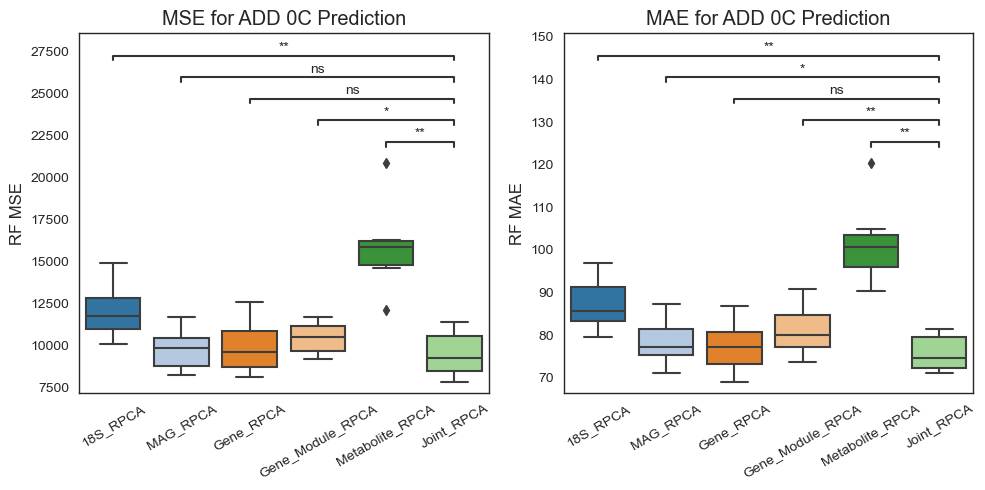

In [13]:
#focus on active vs all task
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'palette':'tab20', 
                   'data': rf_reg_add, 'order':order}

fig, axn = plt.subplots(1, 2, figsize=(10, 5))
for ax_, metric in zip(axn.flatten(), ['MSE', 'MAE']):
    
    plotting_params['y'] = metric
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF {}'.format(metric))
    ax_.set_title('{} for ADD 0C Prediction'.format(metric))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

In [14]:
#add 0c with criterion = absolute_error (MAE)
rf_reg_add_mae = rf_regression(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                           ord_gene_module, ord_metabolite, ord_joint],
                               ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                        "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],  
                               shared_mt=metadata, cat_of_interest='add_0c', 
                               criterion="absolute_error", ordination=True, 
                               random_state=42, bootstrap=True)

display(rf_reg_add_mae.head())

,Omic,Fold,MSE,MAE,Optimization
0,18S_RPCA,traintest_0,11395.312009,82.354313,None
1,18S_RPCA,traintest_1,10371.632001,80.390891,None
2,18S_RPCA,traintest_2,12927.029047,92.302982,None
3,18S_RPCA,traintest_3,11727.193093,88.506246,None
4,18S_RPCA,traintest_4,12034.069518,84.743978,None


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=4.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:2.324e-01 Stat=1.500e+01
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

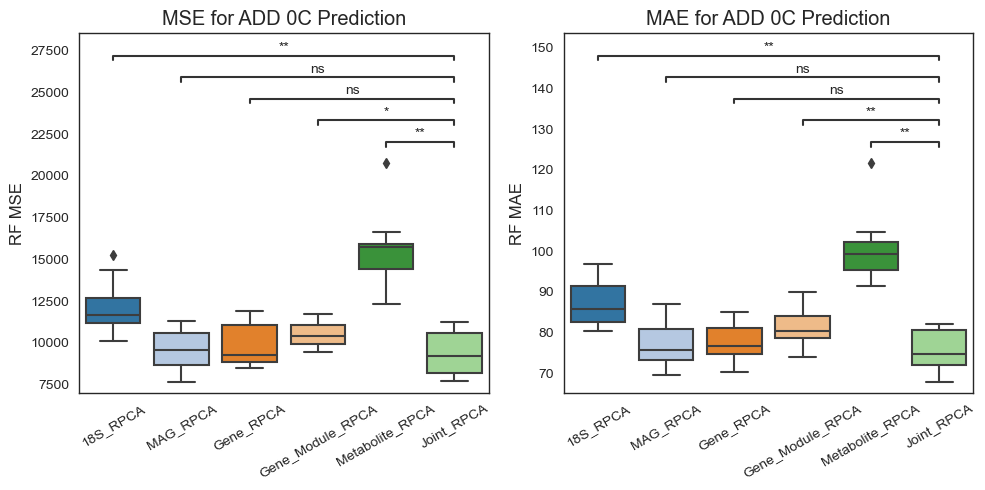

In [15]:
#focus on active vs all task
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'palette':'tab20', 
                   'data': rf_reg_add_mae, 'order':order}

fig, axn = plt.subplots(1, 2, figsize=(10, 5))
for ax_, metric in zip(axn.flatten(), ['MSE', 'MAE']):
    
    plotting_params['y'] = metric
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF {}'.format(metric))
    ax_.set_title('{} for ADD 0C Prediction'.format(metric))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()